In [30]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

In [31]:
# ========== LOAD DATA ==========
DATA_DIR = os.path.join('..', '..', 'data', 'cleaned','joblib_dataframes')

movies = joblib.load(os.path.join(DATA_DIR, 'df_movies_combined_rf.joblib'))
movies = movies.select_dtypes(exclude='object')  # drop all string columns asap

if 'imdb_id' in movies.columns:
    movies = movies.drop(columns=['imdb_id'])

In [32]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5002 entries, 0 to 5001
Columns: 36058 entries, budget_$ to þórunn magnea magnúsdóttir
dtypes: float64(36058)
memory usage: 1.3 GB


In [33]:
# ========== SET TARGET ==========
y = (movies['box_office_$'] > 100_000_000).astype(int)
X = movies.drop(columns=['box_office_$'])

X = X.fillna(0).astype(np.float32)
X_sparse = csr_matrix(X.values)

In [34]:
# ========== FEATURE SELECTION ==========
selector = SelectKBest(score_func=chi2, k=10_000)
X_reduced = selector.fit_transform(X_sparse, y)

# Get the selected feature names from the original DataFrame columns
selected_features = X.columns[selector.get_support()]

In [35]:
# ========== SPLIT ==========
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [36]:
# ========== TRAIN ==========
model = RandomForestClassifier(n_estimators=100,
                               max_depth=10,
                               class_weight='balanced',
                               random_state=42,
                               n_jobs=-1)

model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



Training set size: 4001 samples
Testing set size: 1001 samples
**************************************************
Accuracy: 0.8901
**************************************************

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       841
           1       0.67      0.62      0.65       160

    accuracy                           0.89      1001
   macro avg       0.80      0.78      0.79      1001
weighted avg       0.89      0.89      0.89      1001

**************************************************

Confusion Matrix:


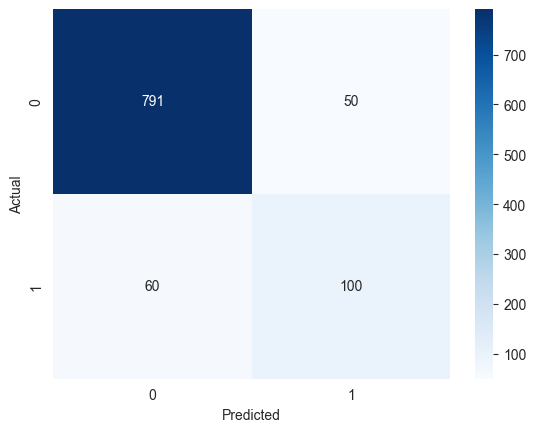


ROC-AUC Curve


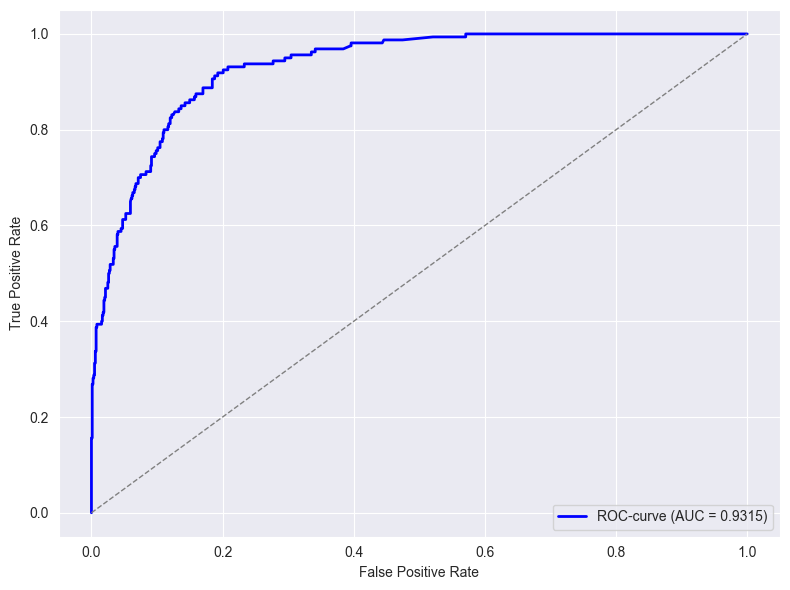

In [37]:
# ========== PREDICT & EVALUATIE ==========
y_pred = model.predict(X_test)

print(f"\nTraining set size: {X_train.shape[0]} samples") #.shape[0] = number of samples (rows)
print(f"Testing set size: {X_test.shape[0]} samples")
print(50*'*')
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(50*'*')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(50*'*')

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nROC-AUC Curve")
y_prob = model.predict_proba(X_test)[:, 1]  # kans op klasse 1
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC-curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

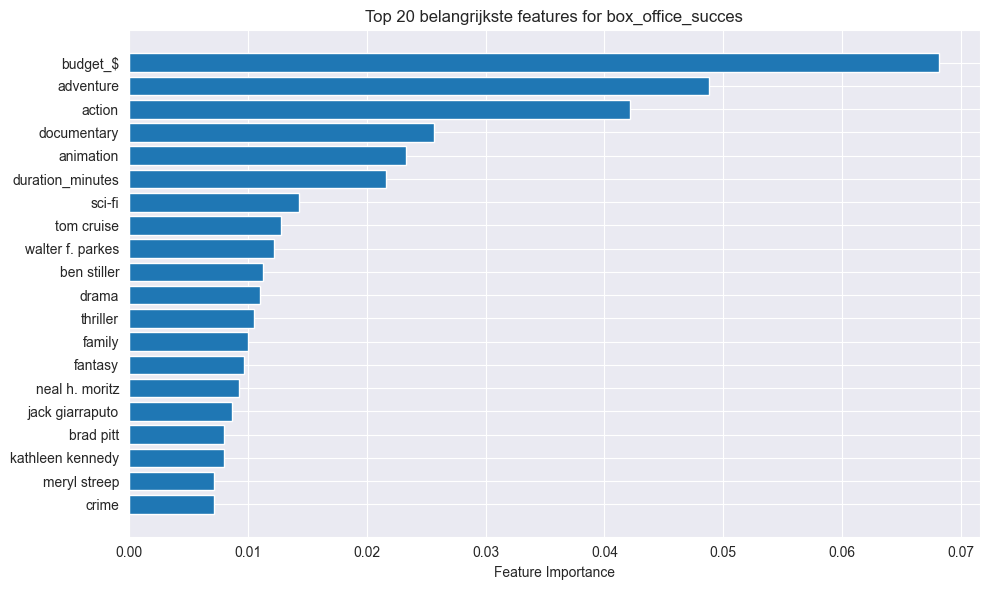

In [38]:
# ========== PLOT FEATURE IMPORTANCES ==========
importances = pd.Series(model.feature_importances_, index=selected_features)

top_n = 20
top_features = importances.nlargest(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features.index[::-1], top_features.values[::-1])  # reversed for descending order
plt.xlabel("Feature Importance")
plt.title("Top 20 belangrijkste features for box_office_succes")
plt.tight_layout()
plt.show()